# Data Loader

In [1]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

2022-11-29 22:10:27.038489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 22:10:27.038525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [12]:
import os
from os.path import exists
import cv2

class CustomGen(keras.utils.Sequence):

    def __init__(self, img_path, img_path_mask, batch_size):
        self.img_path = img_path
        self.img_path_mask = img_path_mask
        self.batch_size = batch_size
        self.list_elements = os.listdir(self.img_path)
        self.list_elements_mask = os.listdir(self.img_path_mask)

    def __len__(self):
#         self.list_elements = os.listdir(self.img_path)
#         self.list_elements_mask = os.listdir(self.img_path_mask)
        return len(self.list_elements) // self.batch_size

    def __getitem__(self,idx):        
        X_paths = self.list_elements[idx * self.batch_size:(idx+1) * self.batch_size]
        y_paths = self.list_elements_mask[idx * self.batch_size:(idx+1) * self.batch_size]

        X = []
        y = []

        for x_filename in X_paths:
            X.append(load_img(self.img_path + x_filename))
            y_filename = x_filename.replace('.jpg','_mask.jpg')
            y_path = self.img_path_mask + y_filename
            file_exists = exists(y_path)
            if file_exists:
                # y.append(load_img('../data/Oil Tanks/image_patches/'+x_filename))
                temp_y = np.array(load_img(y_path))[:, :, 0:1]
                y.append(temp_y)
            else:
#                 import ipdb; ipdb.set_trace()
                img = cv2.imread(self.img_path + x_filename)
                black_img = (img*0)[:, :, 0:1]
                y.append(black_img)

        return np.stack(X)/255., np.stack(y)/255.

In [13]:
img_path = '../data/Oil Tanks/image_patches/'
img_path_mask = '../data/case1_tanks/output_mask/'
batch_size = 8

In [14]:
data_loader = CustomGen(img_path, img_path_mask, batch_size)

### Test Data loader

In [24]:
X,y = data_loader.__getitem__(42)

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(X[0])

plt.subplot(1,2,2)
plt.imshow(y[0], cmap ='gray')

In [ ]:
X[0].shape, y[0].shape

In [ ]:
X.shape, y.shape

### UNET Function

In [23]:
from tensorflow.keras import layers, Model
from PIL import Image
import PIL 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ast
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

In [25]:
def get_model(img_size, num_classes):
    inputs = layers.Input(shape = img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model

In [ ]:
img_size = (512,512)
num_classes = 1

In [ ]:
# Build model
model = get_model(img_size, num_classes)
model.summary()

In [ ]:
#Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)


history = model.fit(X, y,
          batch_size=2,
          epochs=10,
          validation_split=0.2,
          callbacks=[es],
          verbose=1)

In [ ]:
history.history

### image resize in-progress

In [34]:
from tensorflow.image import resize
from tensorflow.keras import utils

In [35]:
image_temp = utils.load_img(
    '../data/Oil Tanks/image_patches/01_0_0.jpg',
    grayscale=False,
    color_mode='rgb',
    target_size=None,
    interpolation='nearest'
)

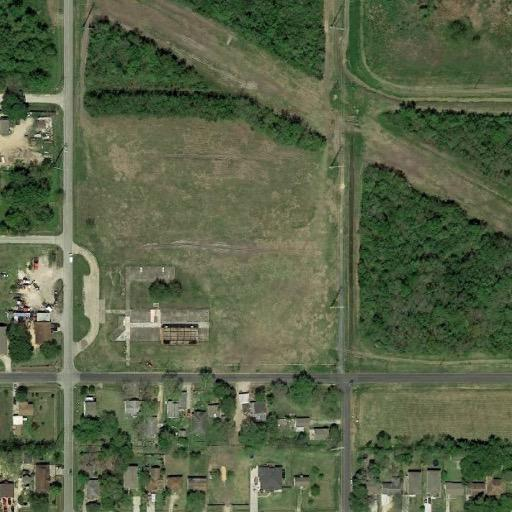

In [41]:
image_temp

In [42]:
np.array(image_temp).shape

(512, 512, 3)

In [43]:
image_temp_resized = resize(
    image_temp,
    [256,256],
    preserve_aspect_ratio=True,
    antialias=False,
    name=None
)

2022-11-30 10:50:24.690116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dushyant/.pyenv/versions/3.8.12/envs/oil-tanker-project/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-30 10:50:24.690178: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 10:50:24.690204: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SLB-G6MC3Z2): /proc/driver/nvidia/version does not exist
2022-11-30 10:50:24.691313: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

In [45]:
image_temp_resized.shape

TensorShape([256, 256, 3])

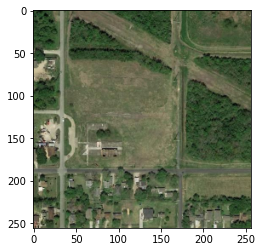

In [47]:
plt.imshow(image_temp_resized/255)